### Importação das bibliotecas

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, Input, concatenate, add
from tensorflow.keras.layers import Conv2D, MaxPooling2D,MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, RMSprop

from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, confusion_matrix

### Leitura do conjunto de dados

In [2]:
os.mkdir('augmented_breakhis')
os.mkdir('augmented_breakhis/benign')
os.mkdir('augmented_breakhis/malignant')

In [3]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [4]:
import shutil

In [5]:
files_benign = getListOfFiles('BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        
        shutil.copy(f,'augmented_breakhis/benign')

In [6]:
files_malignant = getListOfFiles('BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        
        shutil.copy(f,'augmented_breakhis/malignant')

### Carregamento dos dados de cada classe

In [85]:
benign_images = getListOfFiles('BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/40X')
malignant_images = getListOfFiles('BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/40X')

### Visualização dos dados

In [86]:
from tensorflow.keras.preprocessing import image

Benign


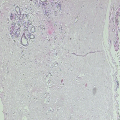

In [87]:
print('Benign')
image.load_img(benign_images[2], target_size=(120,120,1), grayscale=False)

Malignant


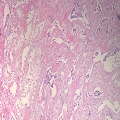

In [88]:
print('Malignant')
image.load_img(malignant_images[10], target_size=(120,120,1), grayscale=False)

In [89]:
total_images = len(benign_images) + len(malignant_images)
print(total_images)

1995


### Gerando targets

In [90]:
import pandas as pd

In [91]:
data = pd.DataFrame(index=np.arange(0, len(benign_images) + len(malignant_images)), columns=["image", "target"])

In [92]:
k=0
for c in [0,1]:
        if c==0:
            for m in range(len(benign_images)):
                data.iloc[k]["image"] = benign_images[m]
                data.iloc[k]["target"] = 0
                k += 1

        else:
            for m in range(len(malignant_images)):
                data.iloc[k]["image"] = malignant_images[m]
                data.iloc[k]["target"] = 1
                k += 1            

In [93]:
data.shape

(1995, 2)

In [94]:
data.head(7900)

,image,target
0,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,0
1,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,0
2,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,0
3,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,0
4,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,0
...,...,...
1990,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,1
1991,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,1
1992,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,1
1993,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,1


### Verificando desbalanceamento dos dados

In [95]:
count_data = data["target"].value_counts()
count_data

1    1370
0     625
Name: target, dtype: int64

C:\Users\anaav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


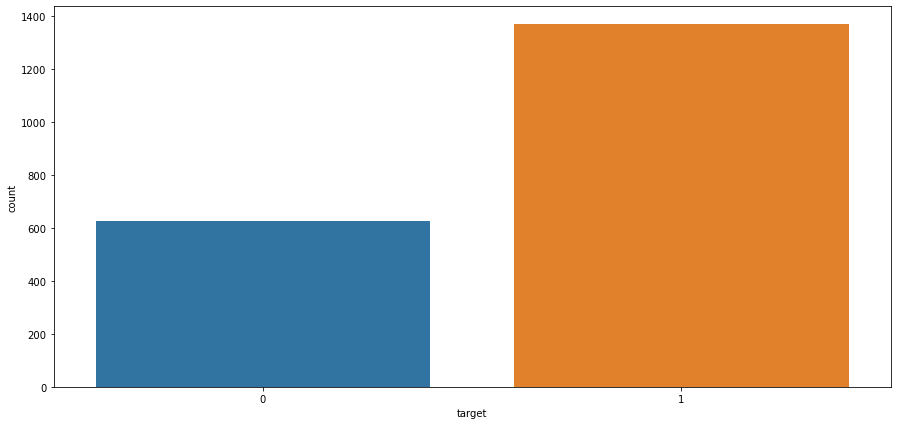

In [96]:
import seaborn as sns
ax = plt.subplots(figsize = (15,7))
target = sns.countplot(data["target"])
plt.show()

In [97]:
from sklearn.utils import resample

In [98]:
ben_upsampled = resample(data[data['target']==0],n_samples=data[data['target']==1].shape[0], random_state=42)

up_sampled = pd.concat([data[data['target']==1], ben_upsampled])

up_sampled['target'].value_counts()

0    1370
1    1370
Name: target, dtype: int64

C:\Users\anaav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


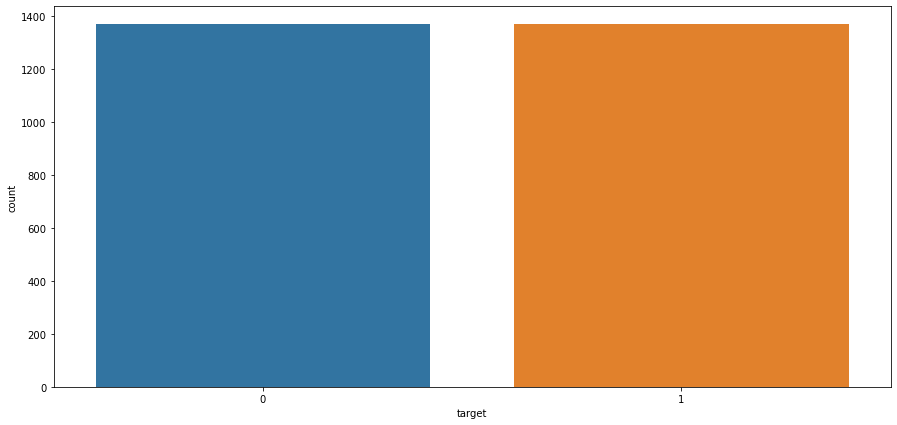

In [99]:
import seaborn as sns
ax = plt.subplots(figsize = (15,7))
target = sns.countplot(up_sampled["target"])
plt.show()

In [100]:
up_sampled.shape

(2740, 2)

In [101]:
up_sampled

,image,target
625,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,1
626,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,1
627,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,1
628,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,1
629,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,1
...,...,...
215,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,0
146,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,0
335,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,0
167,BreaKHis/BreaKHis_v1/BreaKHis_v1/histology_sli...,0


In [102]:
from tqdm import tqdm

In [103]:
from tensorflow.keras.utils import to_categorical

In [104]:
train_image = []
y = []

for i in tqdm(range(data.shape[0])):
    img = image.load_img(data['image'].iloc[i], target_size=(150,150), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)


100%|██████████████████████████████████████████████████████████████████████████████| 1995/1995 [01:56<00:00, 17.19it/s]


In [105]:
from sklearn.model_selection import train_test_split

X = np.array(train_image)
y = data.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30, test_size=0.3, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=30, test_size=0.2 , shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1396, 150, 150, 3)
(479, 150, 150, 3)
(120, 150, 150, 3)


### Transferência de conhecimento

In [106]:
from tensorflow.keras.models import load_model, model_from_json

In [107]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

In [108]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [126]:
def create_model():
    json_file = open('model_vgg.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('model_vgg.h5')
    
    for layer in loaded_model.layers[:]:
        layer.trainable = False

    for layer in loaded_model.layers:
        print(layer, layer.trainable)
    
    model = Sequential(loaded_model.layers[:-2], name='dense3')
    model.add(BatchNormalization(name='batch'))
    model.add(Flatten(name='flatten1'))
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))   
    model.summary()
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['acc',f1_m,precision_m, recall_m])
    
    return model

In [127]:
model = create_model()

<tensorflow.python.keras.engine.functional.Functional object at 0x0000026245167880> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000262457F5400> False
<tensorflow.python.keras.layers.core.Flatten object at 0x0000026248582160> False
<tensorflow.python.keras.layers.core.Dense object at 0x0000026245815B50> False
<tensorflow.python.keras.layers.core.Dropout object at 0x00000262485A9760> False
<tensorflow.python.keras.layers.core.Dense object at 0x00000262485B8B20> False
Model: "dense3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
________

In [111]:
X_train=np.asarray(X_train).astype(np.int)

y_train=np.asarray(y_train).astype(np.int)

X_test=np.asarray(X_test).astype(np.int)

y_test=np.asarray(y_test).astype(np.int)

In [128]:
history = model.fit(X_train, y_train, epochs = 20, validation_data=(X_test, y_test))

Epoch 1/20
44/44 [==============================] - 256s 6s/step - loss: 0.7130 - acc: 0.6368 - f1_m: 0.7441 - precision_m: 0.6934 - recall_m: 0.8258 - val_loss: 0.6157 - val_acc: 0.6806 - val_f1_m: 0.8057 - val_precision_m: 0.6808 - val_recall_m: 0.9961
Epoch 2/20
44/44 [==============================] - 229s 5s/step - loss: 0.6375 - acc: 0.6597 - f1_m: 0.7796 - precision_m: 0.6948 - recall_m: 0.8969 - val_loss: 0.5908 - val_acc: 0.6827 - val_f1_m: 0.8053 - val_precision_m: 0.6838 - val_recall_m: 0.9888
Epoch 3/20
44/44 [==============================] - 254s 6s/step - loss: 0.6311 - acc: 0.6540 - f1_m: 0.7789 - precision_m: 0.6900 - recall_m: 0.9050 - val_loss: 0.5842 - val_acc: 0.6827 - val_f1_m: 0.8051 - val_precision_m: 0.6849 - val_recall_m: 0.9867
Epoch 4/20
44/44 [==============================] - 252s 6s/step - loss: 0.6072 - acc: 0.6798 - f1_m: 0.7944 - precision_m: 0.7000 - recall_m: 0.9275 - val_loss: 0.5797 - val_acc: 0.6848 - val_f1_m: 0.8064 - val_precision_m: 0.6853 - v

KeyboardInterrupt: 

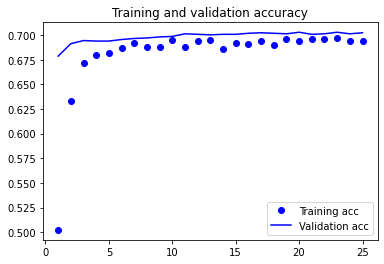

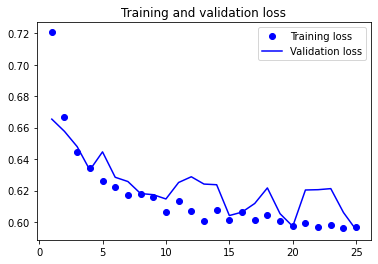

In [37]:
acc = history.history['acc']

val_acc = history.history['val_acc'] 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')

In [38]:
X_val=np.asarray(X_val).astype(np.int)

y_val=np.asarray(y_val).astype(np.int)

In [41]:
loss, accuracy, f1_score = model.evaluate(X_test, y_test, verbose=0)

In [43]:
print('val_accuracy', accuracy)
print('val_loss', loss)
print('f1_score', f1_score)

val_accuracy 0.7023182511329651
val_loss 0.5950363278388977
f1_score 0.8147875666618347
